# コード2-4：非線形常微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

非線形常微分方程式を数値計算する例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [2]:
## 必要があればインストール
# install.packages("ggplot2", "patchwork", "deSolve)

In [3]:
rm(list = ls(all = TRUE))
library(ggplot2)
library(patchwork)
library(deSolve)

## 非線形常微分方程式の数値計算

式（2.12）

$$
\begin{align}
\frac{d T \left( t \right)}{dt} &= L(t) - \beta T(t) V(t) \\
\frac{d I \left( t \right)}{dt} &= \beta T(t) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について
1. $L(t) = \lambda - d T(t), \lambda = 0, d = 0.057, \beta = 8.61 \times 10^{-11}, \delta = 0.057 + 1.75, p = 3.26 \times 10^4, c = 1.93 + 0.039, T(0) = 6.46 \times 10^6, I(0) = 10^{-1}, V(0) = 5.0 \times 10^4$
2. $L(t) =g T(t) \left( 1 - \frac{T(t)}{K} \right), g = 0.6, K = 10^7, \beta = 3.0 \times 10^{-11}, \delta = 0.5, p = 5.0 \times 10^4, c = 10, T(0) = 10^6, I(0) = 10, V(0) = 2.0 \times 10^3$

の時の$T(t), I(t), V(t)$を数値計算によって求める。

※1はできるだけ式2.13、図2.5および表2.1に合わせた。

deSolveパッケージに含まれるode関数を使う。
https://www.rdocumentation.org/packages/deSolve/versions/1.40/topics/ode

In [5]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 20.0
step_size <- 0.0001

## パラメータの設定
## 1. lambda, d, beta, delta, p, c, T(0), I(0), V(0)
pars1 <- c(0.0, 0.057, 8.61*(10.0^-11.0),
          0.057 + 1.75, 3.26*(10.0^4.0), 1.93 + 0.039,
          6.46*(10.0^6.0), 10.0^-1.0, 5.0*(10.0^4.0))

## 2. g, K, beta, delta, p, c, T(0), I(0), V(0)
pars2 <- c(0.6, 10.0^7.0, 3.0*(10.0^-11.0),
          0.5, 5.0*(10.0^4.0), 10.0,
          10.0^6.0, 10.0, 2000.0)

In [6]:
## 傾き（微分）の定義
ode_derives1 <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        ## var: T(t), I(t), V(t)
        dTdt <- plambda - d * TC - beta * TC * VL
        dIdt <- beta * TC * VL - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dTdt, dIdt, dVdt)))
    })
}

ode_derives2 <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        ## var: T(t), I(t), V(t)
        dTdt <- g * TC * (1.0 - (TC/K)) - beta * TC * VL
        dIdt <- beta * TC * VL - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dTdt, dIdt, dVdt)))
    })
}

## パラメータを受け取ってode関数に渡す関数
ODEs1 <- function(parms) {
    pars <- parms[1:6]
    names(pars) <- c("plambda", "d", "beta", "delta", "p", "c")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[7], IC = parms[8], VL = parms[9])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives1, parms = pars)
    
    as.data.frame(out)
}

ODEs2 <- function(parms) {
    pars <- parms[1:6]
    names(pars) <- c("g", "K", "beta", "delta", "p", "c")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(TC = parms[7], IC = parms[8], VL = parms[9])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives2, parms = pars)
    
    as.data.frame(out)
}

In [8]:
out1 <- ODEs1(pars1)
out2 <- ODEs2(pars2)

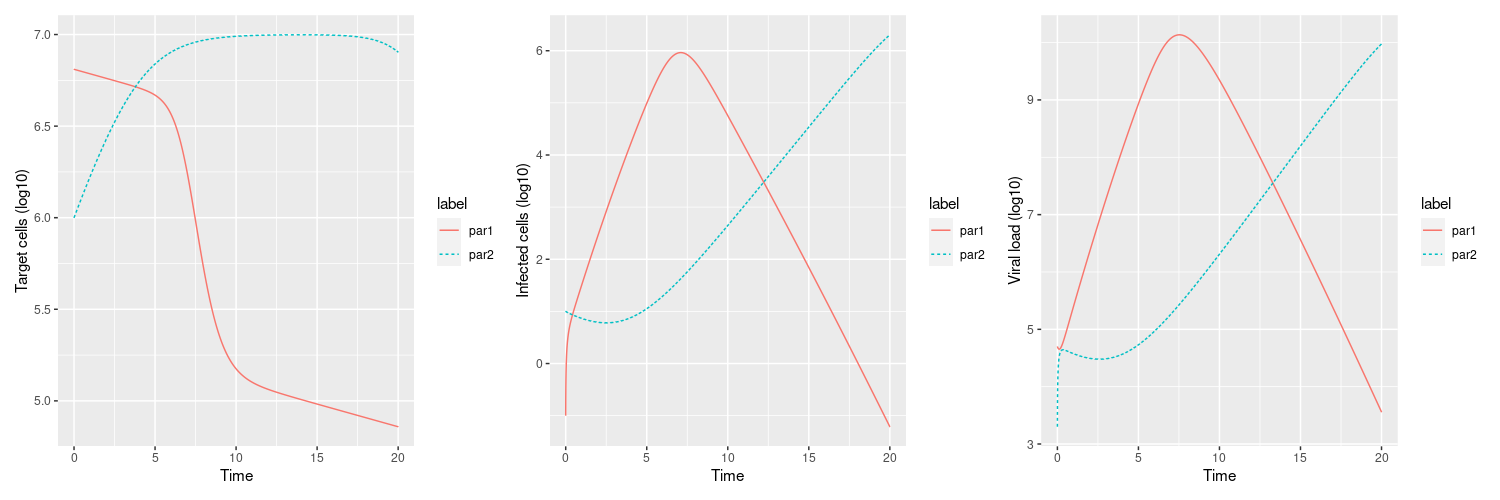

In [12]:
data_plot <- rbind(cbind(out1, label = "par1"),
                   cbind(out2, label = "par2"))

p1 <- ggplot(data = data_plot, aes(x = time, y = log10(TC), color = label, linetype = label)) +
    geom_line() +
    xlab("Time") +
    ylab("Target cells (log10)")

p2 <- ggplot(data = data_plot, aes(x = time, y = log10(IC), color = label, linetype = label)) +
    geom_line() +
    xlab("Time") +
    ylab("Infected cells (log10)")

p3 <- ggplot(data = data_plot, aes(x = time, y = log10(VL), color = label, linetype = label)) +
    geom_line() +
    xlab("Time") +
    ylab("Viral load (log10)")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2 + p3